In [1]:
import numpy as np

import cv2
from statistics import median_high
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, ZeroPadding2D,Activation, AveragePooling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score

2025-04-28 04:22:41.976781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745814162.174189      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745814162.229462      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path_train = "/kaggle/input/brainmri/Datasest Merged 1/Datasest Merged 1"

In [3]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = {}
for i, classes in enumerate(class_names, start=0):
  class_labels[classes] = i

In [4]:
image_size = (130, 130)

In [5]:
#For Training data

train_data = []
train_labels = []

for folder in os.listdir(path_train):
    print("In folder: {}".format(folder))
    for file in os.listdir(os.path.join(path_train, folder)):
        image_path = os.path.join(path_train, folder, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, image_size)  # Resize the image using image_size
        train_data.append(image)
        train_labels.append(class_labels[folder])

train_data = np.array(train_data, dtype='float32')
train_labels = np.array(train_labels, dtype='int32')

train_data = train_data / 255.0 

In folder: pituitary
In folder: notumor
In folder: meningioma
In folder: glioma


In [6]:
train_data[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.01176471,
        0.00392157],
       ...,
       [0.00392157, 0.00784314, 0.00392157, ..., 0.00784314, 0.01176471,
        0.01176471],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

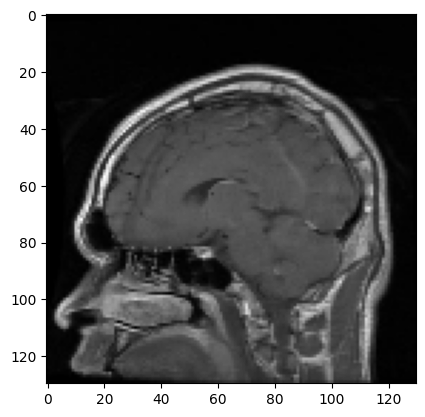

In [7]:
plt.imshow(train_data[0], cmap='gray')

In [8]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_labels)
labels_encoded = to_categorical(labels_encoded)

# Print the mapping of labels to their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 0, 1: 1, 2: 2, 3: 3}


In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=42, shuffle=True)

# Convert to numpy arrays and reshape
X_train = np.array(X_train).reshape(-1, 130, 130, 1)
X_test = np.array(X_test).reshape(-1, 130, 130, 1)

# Define number of classes
num_classes = len(np.unique(train_labels))

print(num_classes)

4


In [10]:
# Resize images before converting to numpy arrays
X_train_resized = np.array([cv2.resize(img, (156, 156)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (156, 156)) for img in X_test])

# Reshape
X_train_resized = X_train_resized.reshape(-1, 156, 156, 1)
X_test_resized = X_test_resized.reshape(-1, 156, 156, 1)


In [40]:
import numpy as np
print("y_train classes:", np.unique(y_train))
print("y_test classes:", np.unique(y_test))

y_train classes: [0 1 2 3]
y_test classes: [0 1 2 3]


In [42]:
import keras
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=4)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=4)

# Verify the shape (should be (n_samples, 4) for both)
print("y_train_categorical shape:", y_train_categorical.shape)
print("y_test_categorical shape:", y_test_categorical.shape)

y_train_categorical shape: (9345, 4)
y_test_categorical shape: (4006, 4)


# ResNet-50

In [43]:
from tensorflow.keras.layers import Add, Flatten
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Saving the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First layer
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X
def ResNet50(input_shape=(130, 130, 1), classes=4):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(4, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

model_ResNet50 = ResNet50(input_shape=(130, 130, 1), classes=4)

In [46]:
model_ResNet50.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history1 = model_ResNet50.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=64,
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3911 - loss: 1.4483
Epoch 1: val_accuracy improved from -inf to 0.26378, saving model to best_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 116s 446ms/step - accuracy: 0.3917 - loss: 1.4465 - val_accuracy: 0.2638 - val_loss: 1.4914
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5745 - loss: 0.9905
Epoch 2: val_accuracy improved from 0.26378 to 0.27180, saving model to best_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 31s 263ms/step - accuracy: 0.5746 - loss: 0.9904 - val_accuracy: 0.2718 - val_loss: 1.8216
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6302 - loss: 0.8755
Epoch 3: val_accuracy improved from 0.27180 to 0.28518, saving model to best_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 30s 258ms/step - accuracy: 0.6303 - loss: 0.8753 - val_accuracy: 0.2852 - val_loss: 1.9400
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6817 - loss: 0.7912
Epoch 4: val_accuracy i

# ResNet-50 With EfficientNet Capabilities

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Add, ZeroPadding2D, Input
from tensorflow.keras.models import Model

def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def ResNet50_Scaled(input_shape=(156, 156, 1), classes=4):
    """
    ResNet50 with scaled parameters but original layer counts.
    """
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(77, (7, 7), strides=(2, 2), name='conv1')(X)  # 64 * 1.2 = 77
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[77, 77, 307], stage=2, block='a', s=1)
    X = identity_block(X, 3, [77, 77, 307], stage=2, block='b')
    X = identity_block(X, 3, [77, 77, 307], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[154, 154, 614], stage=3, block='a', s=2)
    X = identity_block(X, 3, [154, 154, 614], stage=3, block='b')
    X = identity_block(X, 3, [154, 154, 614], stage=3, block='c')
    X = identity_block(X, 3, [154, 154, 614], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[307, 307, 1229], stage=4, block='a', s=2)
    X = identity_block(X, 3, [307, 307, 1229], stage=4, block='b')
    X = identity_block(X, 3, [307, 307, 1229], stage=4, block='c')
    X = identity_block(X, 3, [307, 307, 1229], stage=4, block='d')
    X = identity_block(X, 3, [307, 307, 1229], stage=4, block='e')
    X = identity_block(X, 3, [307, 307, 1229], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[614, 614, 2458], stage=5, block='a', s=2)
    X = identity_block(X, 3, [614, 614, 2458], stage=5, block='b')
    X = identity_block(X, 3, [614, 614, 2458], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D((2, 2), name="avg_pool")(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(2458, activation='relu', name='fc_dense')(X)  # 2048 * 1.2 = 2458
    X = tf.keras.layers.Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc_output')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50_Scaled')
    return model

# Instantiate the model
model_ResNet50_scaled = ResNet50_Scaled(input_shape=(156, 156, 1), classes=4)

In [ ]:
model_ResNet50_scaled.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history2 = model_ResNet50_scaled.fit(X_train_resized, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=64,
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.3589 - loss: 1.9134
Epoch 1: val_accuracy improved from -inf to 0.29856, saving model to best_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.3592 - loss: 1.9115 - val_accuracy: 0.2986 - val_loss: 1.5011
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.4119 - loss: 1.3815
Epoch 2: val_accuracy did not improve from 0.29856
117/117 ━━━━━━━━━━━━━━━━━━━━ 95s 810ms/step - accuracy: 0.4120 - loss: 1.3811 - val_accuracy: 0.2986 - val_loss: 1.6598
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.4661 - loss: 1.2213
Epoch 3: val_accuracy did not improve from 0.29856
117/117 ━━━━━━━━━━━━━━━━━━━━ 93s 797ms/step - accuracy: 0.4661 - loss: 1.2214 - val_accuracy: 0.2937 - val_loss: 1.6068
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.4713 - loss: 1.1883
Epoch 4: val_accuracy improved from 0.29856 to 0.31942, saving model to best_model.keras
117/117 ━━━━━

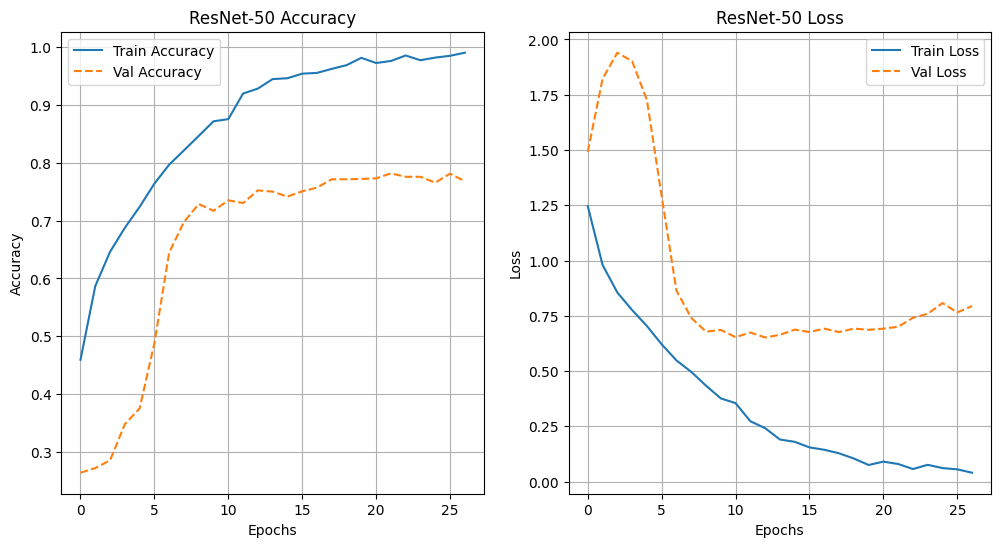

In [51]:
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('ResNet-50 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('ResNet-50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

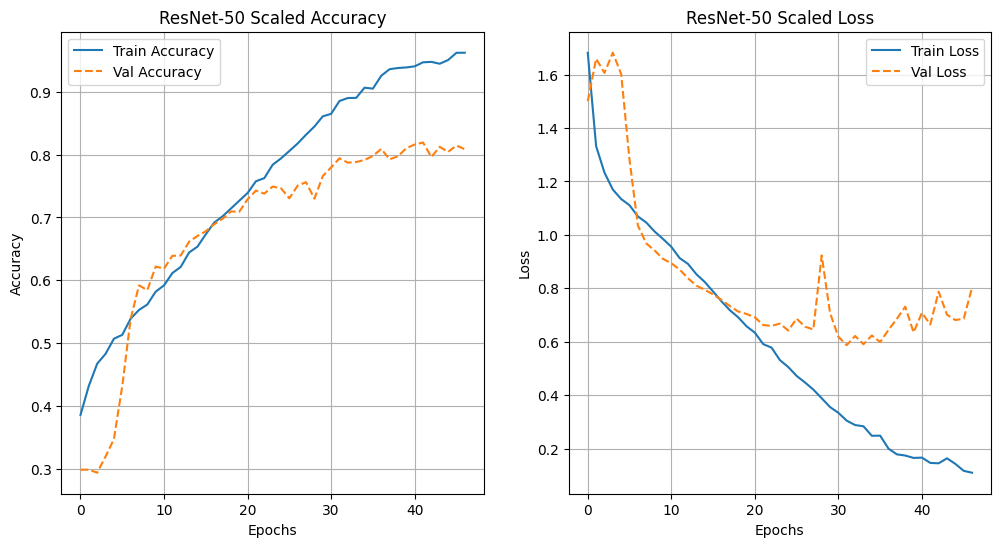

In [52]:
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('ResNet-50 Scaled Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('ResNet-50 Scaled Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Function to calculate specificity and sensitivity for multi-class
def specificity_score_multiclass(conf_matrix):
    specificity_per_class = []
    sensitivity_per_class = []
    
    for i in range(conf_matrix.shape[0]):  # Loop through each class
        tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
        tp = conf_matrix[i, i]
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        specificity_per_class.append(specificity)
        sensitivity_per_class.append(sensitivity)
    
    return specificity_per_class, sensitivity_per_class

# Function to print model metrics and confusion matrix
def print_model_metrics(y_true, y_pred, model_name, class_names):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Compute specificity and sensitivity for each class
    specificity, sensitivity = specificity_score_multiclass(conf_matrix)
    
    # Print metrics
    print(f"\nMetrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: Specificity: {specificity[i]:.4f}, Sensitivity: {sensitivity[i]:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Function to plot one image per class with predicted and true labels
def plot_sample_images_per_class(X, y_true, y_pred, class_names):
    plt.figure(figsize=(12, 8))
    
    shown_classes = set()
    class_indices = {}

    # Find one index per class
    for idx, label in enumerate(y_true):
        if label not in shown_classes:
            class_indices[label] = idx
            shown_classes.add(label)
        if len(shown_classes) == len(class_names):
            break

    for i, (label, idx) in enumerate(class_indices.items()):
        image = X[idx]
        if image.shape[-1] == 1:  # Grayscale
            image = image.squeeze()
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.axis('off')
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")

    plt.suptitle("Sample Image Per Class with Prediction")
    plt.tight_layout()
    plt.show()

# Define your actual class names
class_names = ["Pituitary", "No Tumor", "Meningioma", "Glioma"]



126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step

Metrics for ResNet-50:
Accuracy: 0.7713
Precision: 0.7723
Recall: 0.7713
F1 Score: 0.7717

Pituitary: Specificity: 0.8657, Sensitivity: 0.7196
No Tumor: Specificity: 0.9068, Sensitivity: 0.6969
Meningioma: Specificity: 0.9844, Sensitivity: 0.9341
Glioma: Specificity: 0.9298, Sensitivity: 0.7832


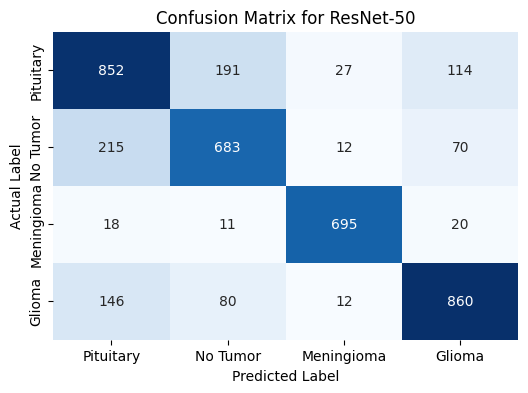


Classification Report:
              precision    recall  f1-score   support

   Pituitary       0.69      0.72      0.71      1184
    No Tumor       0.71      0.70      0.70       980
  Meningioma       0.93      0.93      0.93       744
      Glioma       0.81      0.78      0.80      1098

    accuracy                           0.77      4006
   macro avg       0.78      0.78      0.78      4006
weighted avg       0.77      0.77      0.77      4006



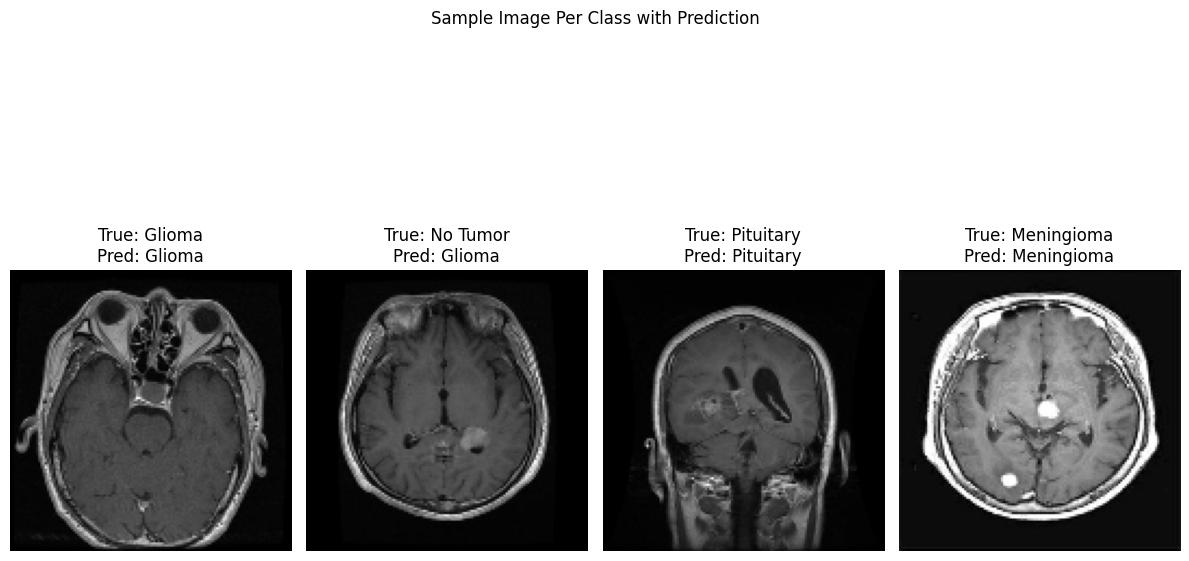

In [57]:
# Get predictions from your trained model
y_pred1 = np.argmax(model_ResNet50.predict(X_test), axis=1)
y_true1 = y_test  # Assuming it's label-encoded already

# Show metrics and plots
print_model_metrics(y_true1, y_pred1, 'ResNet-50', class_names)
plot_sample_images_per_class(X_test, y_true1, y_pred1, class_names)


126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step

Metrics for ResNet-50 Scaled:
Accuracy: 0.8183
Precision: 0.8199
Recall: 0.8183
F1 Score: 0.8181

Pituitary: Specificity: 0.8795, Sensitivity: 0.8007
No Tumor: Specificity: 0.9283, Sensitivity: 0.7235
Meningioma: Specificity: 0.9859, Sensitivity: 0.9812
Glioma: Specificity: 0.9570, Sensitivity: 0.8115


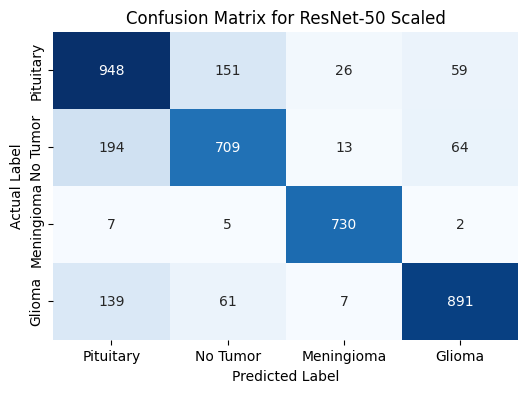


Classification Report:
              precision    recall  f1-score   support

   Pituitary       0.74      0.80      0.77      1184
    No Tumor       0.77      0.72      0.74       980
  Meningioma       0.94      0.98      0.96       744
      Glioma       0.88      0.81      0.84      1098

    accuracy                           0.82      4006
   macro avg       0.83      0.83      0.83      4006
weighted avg       0.82      0.82      0.82      4006



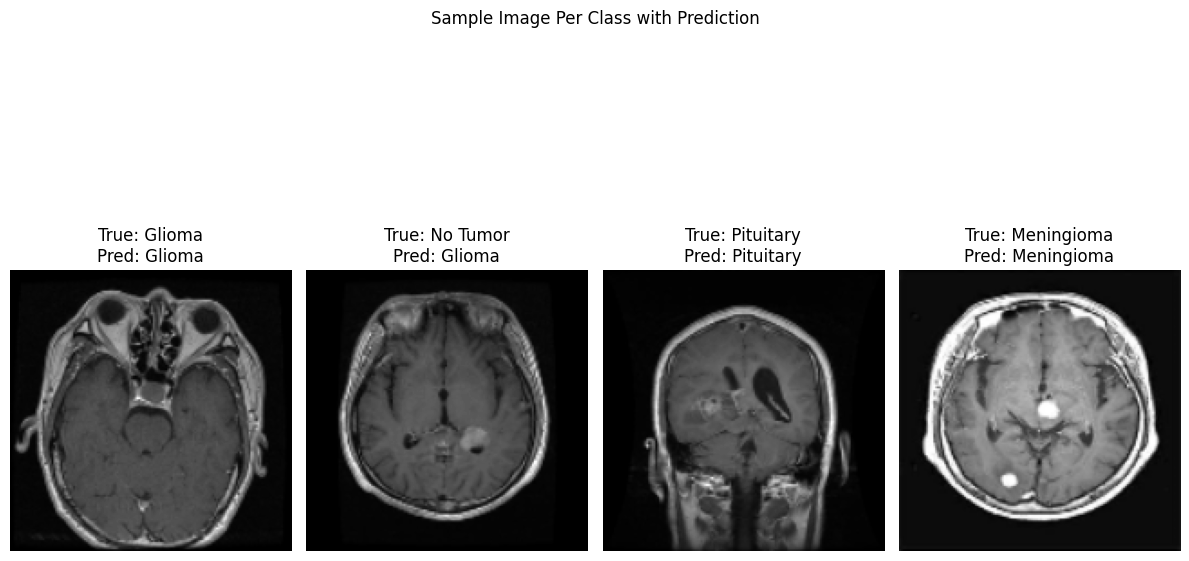

In [ ]:
# Get predictions from your trained model
y_pred1 = np.argmax(model_ResNet50_scaled.predict(X_test_resized), axis=1)
y_true1 = y_test  # Assuming it's label-encoded already

# Show metrics and plots
print_model_metrics(y_true1, y_pred1, 'ResNet-50 Scaled', class_names)
plot_sample_images_per_class(X_test_resized, y_true1, y_pred1, class_names)
